# COMS W4705 - Homework 3
## Conditioned LSTM Language Model for Image Captioning
Triyasha Ghosh Dastidar <tg2936@cs.columbia.edu>

Specifically, you will build the following components:

* Part I (14pts): Create encoded representations for the images in the flickr dataset using a pretrained image encoder(ResNet)
* Part II (14pts): Prepare the input caption data.
* Part III (24pts): Train an LSTM language model on the caption portion of the data and use it as a generator.
* Part IV (24pts): Modify the LSTM model to also pass a copy of the input image in each timestep.
* Part V (24pts): Implement beam search for the image caption generator.

### Getting Started

There are a few required packages.

In [13]:
import os
import PIL # Python Image Library

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import ResNet18_Weights

In [14]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
    print("You won't be able to train the RNN decoder on a CPU, unfortunately.")
print(DEVICE)

cuda


### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail:

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

If you are using Colab:
* The data is available on google drive. You can access the folder here:
https://drive.google.com/drive/folders/1sXWOLkmhpA1KFjVR0VjxGUtzAImIvU39?usp=sharing
* Sharing is only enabled for the lionmail domain. Please make sure you are logged into Google Drive using your Columbia UNI. I will not be able to respond to individual sharing requests from your personal account.

* Once you have opened the folder, click on "Shared With Me", then select the hw5data folder, and press shift+z. This will open the "add to drive" menu. Add the folder to your drive. (This will not create a copy, but just an additional entry point to the shared folder).

N.B.: Usage of this data is limited to this homework assignment. If you would like to experiment with the dataset beyond this course, I suggest that you submit your own download request here (it's free): https://forms.illinois.edu/sec/1713398



If you are running the code locally (or on a cloud VM): I also placed a copy in a Google cloud storage bucket here:
https://storage.googleapis.com/4705-hw5-data/hw5data-20220809T182644Z-001.zip

In [24]:
# OPTIONAL (if not using Colab and the data in Google Drive): Download the data.
!wget https://storage.googleapis.com/4705_fa24_hw3/hw3data.zip

--2024-11-26 00:06:31--  https://storage.googleapis.com/4705_fa24_hw3/hw3data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115435617 (1.0G) [application/zip]
Saving to: ‘hw3data.zip’

hw3data.zip         100%[===================>]   1.04G  40.1MB/s    in 27s     

2024-11-26 00:06:58 (39.6 MB/s) - ‘hw3data.zip’ saved [1115435617/1115435617]



In [ ]:
#Then unzip the data
!unzip hw3data.zip

The following variable should point to the location where the data is located.

In [27]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
MY_DATA_DIR="hw3data"

## Part I: Image Encodings (14 pts)

The files `Flickr_8k.trainImages.txt`, `Flickr_8k.devImages.txt` and `Flickr_8k.testImages.txt`, contain a list of training, development, and test images, respectively. Let's load these lists.

In [28]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f:
        return [line.strip() for line in image_list_f]

In [29]:
FLICKR_PATH="hw3data/"

In [30]:
train_list = load_image_list(os.path.join(FLICKR_PATH, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.devImages.txt'))
test_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.testImages.txt'))

Let's see how many images there are in each of the data subsets

In [31]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [34]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [35]:
IMG_PATH = os.path.join(FLICKR_PATH, "Flickr8k_Dataset")

We can use PIL to open and display the image:

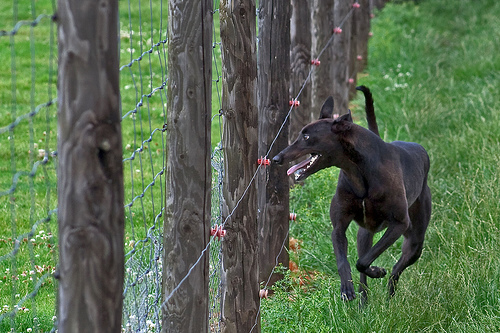

In [36]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

### Preprocessing

We are going to use an off-the-shelf pre-trained image encoder, the ResNet-18 network. Here is more detail about this model (not required for this project):

> Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun; Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778
> https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

The model was initially trained on an object recognition task over the ImageNet1k data. The task is to predict the correct class label for an image, from a set of 1000 possible classes.

To feed the flickr images to ResNet, we need to perform the same normalization that was applied to the training images. More details here: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [37]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

The resulting images, after preprocessing, are (3,224,244) tensors, where the first dimension represents the three color channels, R,G,B).

In [38]:
processed_image = preprocess(image)
processed_image.shape

torch.Size([3, 224, 224])

To the ResNet18 model, the images look like this:

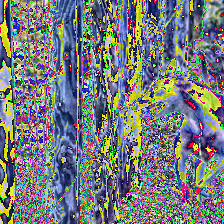

In [39]:
transforms.ToPILImage()(processed_image)

### Image Encoder
Let's instantiate the ReseNet18 encoder. We are going to use the pretrained weights available in torchvision.

In [64]:
img_encoder = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [65]:
img_encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This is a prediction model, so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 512.

We will use the following hack: remove the last layer, then reinstantiate a Sequential model from the remaining layers.

In [66]:
lastremoved = list(img_encoder.children())[:-1]
img_encoder = torch.nn.Sequential(*lastremoved).to(DEVICE) # also send it to GPU memory
img_encoder.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Let's try the encoder.

In [67]:
def get_image(img_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, img_name))
    return preprocess(image)

In [68]:
preprocessed_image = get_image(train_list[0])
encoded = img_encoder(preprocessed_image.unsqueeze(0).to(DEVICE)) # unsqueeze required to add batch dim (3,224,224) becomes (1,3,224,224)
encoded.shape

torch.Size([1, 512, 1, 1])

The result isn't quite what we wanted: The final representation is actually a 1x1 "image" (the first dimension is the batch size).
We can just grab this one pixel:

In [ ]:
encoded = encoded[:,:,0,0] #this is our final image encoded
encoded.shape

torch.Size([1, 512])

**TODO:** Because we are just using the pretrained encoder, we can simply encode all the images in a preliminary step. We will store them in one big tensor (one for each dataset, train, dev, test). This will save some time when training the conditioned LSTM because we won't have to recompute the image encodings with each training epoch. We can also save the tensors to disk so that we never have to touch the bulky image data again.

Complete the following function that should take a list of image names and return a tensor of size [n_images, 512] (where each row represents one image).

For example `encode_imates(train_list)` should return a [6000,512] tensor.

In [ ]:
def encode_images(image_list):
    """
    Encodes a list of image paths into a tensor of size [n_images, 512].

    Parameters:
    - image_list: List of paths to the image files.

    Returns:
    - encodings: Tensor of shape [n_images, 512] with image encodings.
    """
    encodings = []

    for image_name in image_list:
      image = get_image(image_name)
      encoded = img_encoder(image.unsqueeze(0).to(DEVICE))
      encoded = encoded[:,:,0,0]
      encodings.append(encoded)
    return encodings

with torch.no_grad():
  enc_images_train = encode_images(train_list)

enc_images_train = torch.cat(enc_images_train, dim=0)

In [ ]:
enc_images_train.shape

torch.Size([6000, 512])

We can now save this to disk:

In [ ]:
torch.save(enc_images_train, open('encoded_images_train.pt','wb'))

It's a good idea to save the resulting matrices, so we do not have to run the encoder again.

## Part II Text (Caption) Data Preparation (14 pts)

Next, we need to load the image captions and generate training data for the language model. We will train a text-only model first.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file.
The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a \<START\> token on the left and an \<END\> token on the right.

For example, a single caption might look like this:
['\<START\>',
  'a',
  'child',
  'in',
  'a',
  'pink',
  'dress',
  'is',
  'climbing',
  'up',
  'a',
  'set',
  'of',
  'stairs',
  'in',
  'an',
  'entry',
  'way',
  '.',
  '\<EOS\>'],

In [40]:
def read_image_descriptions(filename):
    image_descriptions = {}

    with open(filename, 'r') as in_file:
        for line in in_file:
            words = line.split()
            image_name = words[0].split('#')[0]
            # Add <START> and <EOS> tokens around each description
            description = ['<START>'] + [word.lower() for word in words[1:]] + ['<EOS>']

            # Store each description as a list of words
            if image_name in image_descriptions:
                image_descriptions[image_name].append(description)
            else:
                image_descriptions[image_name] = [description]

    return image_descriptions

In [41]:
os.path.join(FLICKR_PATH, "Flickr8k.token.txt")

'hw3data/Flickr8k.token.txt'

In [42]:
descriptions = read_image_descriptions(os.path.join(FLICKR_PATH, "Flickr8k.token.txt"))

In [43]:
descriptions['1000268201_693b08cb0e.jpg']

[['<START>',
  'a',
  'child',
  'in',
  'a',
  'pink',
  'dress',
  'is',
  'climbing',
  'up',
  'a',
  'set',
  'of',
  'stairs',
  'in',
  'an',
  'entry',
  'way',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'girl',
  'going',
  'into',
  'a',
  'wooden',
  'building',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'climbing',
  'into',
  'a',
  'wooden',
  'playhouse',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'climbing',
  'the',
  'stairs',
  'to',
  'her',
  'playhouse',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'in',
  'a',
  'pink',
  'dress',
  'going',
  'into',
  'a',
  'wooden',
  'cabin',
  '.',
  '<EOS>']]

The previous line should return
<pre>[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<EOS>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'buil[link text](https://)ding', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<EOS>']]</pre>

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input
and output sequences using numeric representations.

**TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries.

Make sure you create word indices for the three special tokens `<PAD>`, `<START>`, and `<EOS>` (end of sentence).

In [46]:
# Initialize special tokens in the mappings
id_to_word = {0: "<PAD>", 1: "<START>", 2: "<EOS>"}
word_to_id = {"<PAD>": 0, "<START>": 1, "<EOS>": 2}

# Set to collect unique words from the descriptions
all_words = set()

# Collect all unique words from the image descriptions
for desc in descriptions.values():
    for token in desc:
        all_words.update(token)  # Adds words to the set

# Sort the words to ensure consistent ordering across runs
sorted_words = sorted(all_words)

# Start ID assignment from 3 as 0, 1, 2 are reserved for special tokens
current_id = 3

# Create the mappings based on the sorted words
for word in sorted_words:
    if word in word_to_id:
      continue
    else:
      word_to_id[word] = current_id
      id_to_word[current_id] = word
      current_id += 1

In [47]:
word_to_id['cat'] # should print an integer

1349

In [48]:
id_to_word[1] # should print a token

'<START>'

In [49]:
id_to_word[1349] # verification

'cat'

Note that we do not need an UNK word token because we will only use the model as a generator, once trained.





## Part III Basic Decoder Model (24 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input.

We will use the LSTM implementation provided by PyTorch. The core idea here is that the recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different position, but the weights for these positions are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [ ]:
MAX_LEN = max(len(description) for image_id in train_list for description in descriptions[image_id])
MAX_LEN

40

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word.
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence

`['<START>', 'a', 'black', 'dog', '<EOS>']`

We would train the model using the following input/output pairs (note both sequences are padded to the right up to MAX_LEN)

| i | input                                 | output                              |
|---|---------------------------------------|-------------------------------------|
| 0 |[`<START>`,`<PAD>`,`<PAD>`,`<PAD>`,...]| [`a`,`<PAD>`,`<PAD>`,`<PAD>`,...    |  
| 1 |[`<START>`,`a`,`<PAD>`,`<PAD>`,...]    | [`a`,`black`,`<PAD>`,`<PAD>`,...    |
| 2 |[`<START>`,`a`,`black`,`<PAD>`,...]    | [`a`,`black`,`dog`,`<PAD>`,...      |
| 3 |[`<START>`,`a`,`back`,`dog`,...]       | [`a`,`black`,`dog`,`<EOS>`,...      |

Here is the language model in pytorch. We will choose input embeddings of dimensionality 512 (for simplicitly, we are not initializing these with pre-trained embeddings here). We will also use 512 for the hidden state vector and the output.

In [ ]:
from torch import nn

vocab_size = len(word_to_id)+1
class GeneratorModel(nn.Module):

    def __init__(self):
        super(GeneratorModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 512)
        self.lstm = nn.LSTM(512, 512, num_layers = 1, bidirectional=False, batch_first=True)
        self.output = nn.Linear(512,vocab_size)

    def forward(self, input_seq):
        hidden = self.lstm(self.embedding(input_seq))
        out = self.output(hidden[0])
        return out

The input sequence is an integer tensor of size `[batch_size, MAX_LEN]`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with '<PAD>'.

For each input example, the model returns a distribution over possible output words. The model output is a tensor of size `[batch_size, MAX_LEN, vocab_size]`. vocab_size is the number of vocabulary words, i.e. len(word_to_id)

### Creating a Dataset for the text training data

**TODO**: Write a Dataset class for the text training data. The __getitem__ method should return an (input_encoding, output_encoding) pair for a single item. Both input_encoding and output_encoding should be tensors of size `[MAX_LEN]`, encoding the padded input/output sequence as illustrated above.

I recommend to first read in all captions in the __init__ method and store them in a list. Above, we used the get_image_descriptions function to load the image descriptions into a dictionary. Iterate through the images in img_list, then access the corresponding captions in the `descriptions` dictionary.

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc.


In [ ]:
MAX_LEN = 40

class CaptionDataset(Dataset):

    def __init__(self, img_list):

        self.data = []

        for img_name in img_list:  # Iterate through the list of image names
            if img_name in descriptions:
                for caption in descriptions[img_name]:  # Each caption is a list of words
                  input_sequence = caption[:-1]
                  output_sequence = caption[1:] # Shift by one for output
                  #Encode them and PAD
                  input_encoding = [word_to_id[token] for token in input_sequence] + [word_to_id["<PAD>"]] * (MAX_LEN - len(input_sequence))
                  output_encoding = [word_to_id[token] for token in output_sequence] + [word_to_id["<PAD>"]] * (MAX_LEN - len(output_sequence))
                  self.data.append((torch.tensor(input_encoding, dtype=torch.long), torch.tensor(output_encoding, dtype=torch.long)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self,k):
        return self.data[k]


In [ ]:
# I tried using incremental pair for dataset, but the results were not good. So I shifted to processing one sequence at a time.
# import sys
# MAX_LEN = 40

# class CaptionDataset(Dataset):

#     def __init__(self, img_list):

#         self.data = []

#         for img_name in img_list:  # Iterate through the list of image names
#             if img_name in descriptions:
#                 for caption in descriptions[img_name]:  # Each caption is a list of words
#                     # Encode the caption into integer IDs
#                     encoded_caption = [word_to_id[word] for word in caption]

#                     # Generate incremental input-output pairs
#                     for i in range(1, len(encoded_caption)):
#                         # Input sequence
#                         input_seq = encoded_caption[:i]
#                         input_seq += [word_to_id["<PAD>"]] * (MAX_LEN - len(input_seq))


#                         output_seq = encoded_caption[1:i+1]
#                         output_seq += [word_to_id["<PAD>"]] * (MAX_LEN - len(output_seq))

#                         # Add the pair to the dataset
#                         self.data.append((torch.tensor(input_seq), torch.tensor(output_seq)))

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self,k):
#         return self.data[k]

Let's instantiate the caption dataset and get the first item. You want to see something like this:

for the input:
<pre>
tensor([   1,   74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922,
        7125,   17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
</pre>
for the output:
<pre>
    tensor([  74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922, 7125,
          17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
</pre>

In [ ]:
data = CaptionDataset(train_list)

In [ ]:
i, o = data[0]
print(f"i: {i}\n o: {o}")

i: tensor([   1,   72,  803, 2310, 4013, 6486,  168,   72, 8684, 2310, 3920, 7920,
        7123,   17,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
 o: tensor([  72,  803, 2310, 4013, 6486,  168,   72, 8684, 2310, 3920, 7920, 7123,
          17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [ ]:
i, o = data[1]
print(f"i: {i}\n o: {o}")

i: tensor([   1,  803, 2310, 1436, 1069, 2310, 7965, 7123,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
 o: tensor([ 803, 2310, 1436, 1069, 2310, 7965, 7123,    2,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


Let's try the model:

In [ ]:
model = GeneratorModel().to(DEVICE)

In [ ]:
model(i.to(DEVICE)).shape   # should return a [40, vocab_size]  tensor.

torch.Size([40, 8922])

### Training the Model

The training function is identical to what you saw.

In [ ]:
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss(ignore_index = 0, reduction='mean')

LEARNING_RATE = 1e-03
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

loader = DataLoader(data, batch_size = 16, shuffle = True)

def train():
    """
    Train the model for one epoch.
    """
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    total_correct, total_predictions = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(loader):

        inputs,targets = batch
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        # Run the forward pass of the model
        logits = model(inputs)
        loss = loss_function(logits.transpose(2,1), targets)
        tr_loss += loss.item()
        #print("Batch loss: ", loss.item()) # can comment out if too verbose.
        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=2)  # Predicted token labels
        not_pads = targets != 0  # Mask for non-PAD tokens
        correct = torch.sum((predictions == targets) & not_pads)
        total_correct += correct.item()
        total_predictions += not_pads.sum().item()

        if idx % 100==0:
            torch.cuda.empty_cache() # can help if you run into memory issues
            curr_avg_loss = tr_loss/nb_tr_steps
            print(f"Current average loss: {curr_avg_loss}")

        # Run the backward pass to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy for this batch
        # matching = torch.sum(torch.argmax(logits,dim=2) == targets)
        # predictions = torch.sum(torch.where(targets==-100,0,1))

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accuracy = total_correct / total_predictions if total_predictions != 0 else 0  # Avoid division by zero
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Average accuracy epoch: {epoch_accuracy:.2f}")

Run the training until the accuracy reaches about 0.5 (this would be high for a language model on open-domain text, but the image caption dataset is comparatively small and closed-domain). This will take about 5 epochs.

In [ ]:
# Training to reach an accuracy over 0.5
for i in range(5):
  print(i)
  train()

0
Current average loss: 3.939578056335449
Current average loss: 3.672335983502983
Current average loss: 3.625047886549537
Current average loss: 3.586009225972071
Current average loss: 3.5380560501555256
Current average loss: 3.5038992687613666
Current average loss: 3.4789453409674165
Current average loss: 3.446337483238732
Current average loss: 3.4174380555432684
Current average loss: 3.3973348352408963
Current average loss: 3.3733438542791894
Current average loss: 3.352838138793405
Current average loss: 3.339935076226799
Current average loss: 3.3276079840883668
Current average loss: 3.312811309486351
Current average loss: 3.2985300409404696
Current average loss: 3.2842779229537613
Current average loss: 3.2696693916309587
Current average loss: 3.2599108960481566
Training loss epoch: 3.251663911183675
Average accuracy epoch: 0.39
1
Current average loss: 3.153184413909912
Current average loss: 2.7415573006809346
Current average loss: 2.755116543366541
Current average loss: 2.748909855997

### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>", "<PAD>","<PAD>"...]`, use the model to predict the most likely word in the next position. Append the word to the input sequence and then continue until `"<EOS>"` is predicted or the sequence reaches `MAX_LEN` words.

In [ ]:
def decoder():
    model.eval()
    # Start with the initial sequence ["<START>", "<PAD>", "<PAD>", ...]
    input_seq = [word_to_id["<START>"]] + [word_to_id["<PAD>"]] * (MAX_LEN - 1)
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)

    generated_words = []

    for i in range(MAX_LEN):
        with torch.no_grad():
            output = model(input_seq)

        # Get the most likely word at the current position
        next_word_id = output[0, i].argmax(dim=-1).item()
        next_word = id_to_word[next_word_id]

        # If the predicted word is <EOS>, stop generation
        # Append the predicted word to the generated sequence
        generated_words.append(next_word)
        if next_word == "<EOS>":
            break

        # Update the input sequence for the next time step
        if i + 1 < MAX_LEN:
            input_seq[0, i + 1] = next_word_id

    return generated_words


In [ ]:
decoder()

['a',
 'man',
 'in',
 'a',
 'red',
 'shirt',
 'is',
 'standing',
 'in',
 'front',
 'of',
 'a',
 'building',
 'with',
 'a',
 'mural',
 'painted',
 'on',
 'it',
 '.',
 '<EOS>']

This will return something like:


['a',
 'man',
 'in',
 'a',
 'white',
 'shirt',
 'and',
 'a',
 'woman',
 'in',
 'a',
 'white',
 'dress',
 'walks',
 'by',
 'a',
 'small',
 'white',
 'building',
 '.',
 '<EOS>']

This simple decoder will of course always predict the same sequence (and it's not necessarily a good one).

**TODO:** Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Make sure to apply torch.softmax() to convert the output activations into a distribution.

To sample fromt he distribution, I recommend you take a look at [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), which takes the distribution as a parameter p.

In [ ]:
import numpy as np

def sample_decoder():
    model.eval()
    # Start with <START> and a padded sequence
    input_seq = [word_to_id["<START>"]] + [word_to_id["<PAD>"]] * (MAX_LEN - 1)
    input_seq = torch.tensor(input_seq, device=DEVICE).unsqueeze(0)

    generated_words = []

    for i in range(MAX_LEN):
        with torch.no_grad():
            output = model(input_seq)

        # Apply softmax to get probabilities for the next word at current position
        probs = torch.softmax(output[0, i], dim=-1).cpu().numpy()

        # Sample the next word from the probability distribution
        next_word_id = np.random.choice(len(probs), p=probs)
        next_word = id_to_word[next_word_id]

        generated_words.append(next_word)
        if next_word == "<EOS>":
            break

        # Update the input sequence for the next time step
        if i + 1 < MAX_LEN:
            input_seq[0, i + 1] = next_word_id

    return generated_words


for i in range(5):
    print(sample_decoder())

['the', 'man', 'juggles', 'six', 'balls', 'easily', '.', '<EOS>']
['this', 'dog', 'is', 'dressed', 'as', 'a', 'zombie', 'of', 'people', 'run', 'out', 'of', 'a', 'basement', 'tunnel', 'in', 'a', 'grove', '.', '<EOS>']
['a', 'person', 'holding', 'onto', 'a', 'drum', 'and', 'a', 'red', 'motorcycle', '.', '<EOS>']
['three', 'girls', 'riding', 'in', 'the', 'surf', '.', '<EOS>']
['a', 'dog', 'with', 'floppy', 'ears', 'runs', 'towards', 'the', 'camera', 'behind', 'a', 'jumper', '.', '<EOS>']


Some example outputs (it's stochastic, so your results will vary)

<pre>
['<START>', 'people', 'on', 'rocky', 'ground', 'swinging', 'basketball', '<EOS>']
['<START>', 'the', 'two', 'hikers', 'take', 'a', 'tandem', 'leap', 'while', 'another', 'is', 'involving', 'watching', '.', '<EOS>']
['<START>', 'a', 'man', 'attached', 'to', 'a', 'bicycle', 'rides', 'a', 'motorcycle', '.', '<EOS>']
['<START>', 'a', 'surfer', 'is', 'riding', 'a', 'wave', 'in', 'the', 'ocean', '.', '<EOS>']
['<START>', 'a', 'child', 'plays', 'in', 'a', 'round', 'fountain', '.', '<EOS>']
</pre>

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input.

## Part IV - Conditioning on the Image (24 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image.

We will concatenate the 512-dimensional image representation to each 512-dimensional token embedding. The LSTM will therefore see input representations of size 1024.

**TODO**: Write a new Dataset class for the combined image captioning data set. Each call to __getitem__ should return a triple  (image_encoding, input_encoding, output_encoding) for a single item. Both input_encoding and output_encoding should be tensors of size [MAX_LEN], encoding the padded input/output sequence as illustrated above. The image_encoding is the size [512] tensor we pre-computed in part I.

Note: One tricky issue here is that each image corresponds to 5 captions, so you have to find the correct image for each caption. You can create a mapping from image names to row indices in the image encoding tensor. This way you will be able to find each image by it's name.

In [50]:
MAX_LEN = 40

class CaptionAndImage(Dataset):
    def __init__(self, img_list):

        self.img_data = torch.load(open("encoded_images_train.pt", 'rb'))
        self.img_name_to_id = dict([(i, j) for (j, i) in enumerate(img_list)])  # Map image names to indices

        # Initialize list to store data
        self.data = []

        # Iterate over the image names
        for img_name in img_list:
            if img_name in descriptions:  # Ensure the image has associated captions
                img_num_id = self.img_name_to_id[img_name]

                # Process each caption for the current image
                for caption in descriptions[img_name]:  # Each caption is a list of tokens
                    # Encode the caption into integer IDs
                    encoded_caption = [word_to_id[word] for word in caption]

                    input_encoding = encoded_caption[:-1]
                    output_encoding = encoded_caption[1:]
                    input_encoding = input_encoding + [word_to_id["<PAD>"]] * (MAX_LEN - len(input_encoding))
                    output_encoding = output_encoding + [word_to_id["<PAD>"]] * (MAX_LEN - len(output_encoding))

                    self.data.append((self.img_data[img_num_id], torch.tensor(input_encoding, dtype=torch.long), torch.tensor(output_encoding, dtype=torch.long)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]


In [51]:
joint_data = CaptionAndImage(train_list)


<ipython-input-50-2b6fcaed832d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.img_data = torch.load(open("encoded_images_train.pt", 'rb'))


In [52]:
img, i, o = joint_data[0]
img.shape # should return torch.Size([512])

torch.Size([512])

In [53]:
i.shape # should return torch.Size([40])

torch.Size([40])

In [54]:
o.shape # should return torch.Size([40])

torch.Size([40])

**TODO: Updating the model**
Update the language model code above to include a copy of the image for each position.
The forward function of the new model should take two inputs:
    
   1. a `(batch_size, 512)` ndarray of image encodings.
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences.
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

The LSTM will take input dimension 1024 instead of 512 (because we are concatenating the 512-dim image encoding).

In the forward function, take the image and the embedded input sequence (i.e. AFTER the embedding was applied), and concatenate the image to each input. This requires some tensor manipulation. I recommend taking a look at [torch.Tensor.expand](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) and [torch.Tensor.cat](https://pytorch.org/docs/stable/generated/torch.Tensor.cat.html).



In [55]:
vocab_size = len(word_to_id)+1

class CaptionGeneratorModel(nn.Module):
    def __init__(self):
        super(CaptionGeneratorModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 512, padding_idx=word_to_id["<PAD>"])

        self.lstm = nn.LSTM(1024, 512, num_layers=1, bidirectional=False, batch_first=True)
        self.output = nn.Linear(512, vocab_size)

    def forward(self, image_encodings, input_seq):
        embedded_seq = self.embedding(input_seq)  # Shape: (batch_size, MAX_LEN, 512)
        image_enc_expanded = image_encodings.unsqueeze(1).expand(-1, MAX_LEN, -1)  # Shape: (batch_size, MAX_LEN, 512)
        # Concatenate the image encoding with the embedded sequence
        lstm_input = torch.cat((embedded_seq, image_enc_expanded), dim=-1)  # Shape: (batch_size, MAX_LEN, 1024)

        # Pass through LSTM
        lstm_out, _ = self.lstm(lstm_input)  # Shape: (batch_size, MAX_LEN, 512)

        # Pass through the output layer
        output = self.output(lstm_out)  # Shape: (batch_size, MAX_LEN, vocab_size)
        return output

Let's try this new model on one item:

In [56]:
model = CaptionGeneratorModel().to(DEVICE)

In [57]:
item = joint_data[0]
img, input_seq, output_seq = item

In [58]:
img.shape

torch.Size([512])

In [59]:
logits = model(img.unsqueeze(0).to(DEVICE).long(), input_seq.unsqueeze(0).to(DEVICE).long())

logits.shape # should return (1,40,8922) = (batch_size, MAX_LEN, vocab_size)

torch.Size([1, 40, 8922])

The training function is, again, mostly unchanged. Keep training until the accuracy exceeds 0.5.

In [60]:
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss(ignore_index = 0, reduction='mean')

LEARNING_RATE = 1e-03
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

loader = DataLoader(joint_data, batch_size = 16, shuffle = True)

def train():
    """
    Train the model for one epoch.
    """
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    total_correct, total_predictions = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(loader):

        img, inputs,targets = batch
        img = img.to(DEVICE)
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        # Run the forward pass of the model
        logits = model(img, inputs)
        loss = loss_function(logits.transpose(2,1), targets)
        tr_loss += loss.item()
        #print("Batch loss: ", loss.item()) # can comment out if too verbose.
        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=2)  # Predicted token labels
        not_pads = targets != 0  # Mask for non-PAD tokens
        correct = torch.sum((predictions == targets) & not_pads)
        total_correct += correct.item()
        total_predictions += not_pads.sum().item()

        if idx % 100==0:
            #torch.cuda.empty_cache() # can help if you run into memory issues
            curr_avg_loss = tr_loss/nb_tr_steps
            print(f"Current average loss: {curr_avg_loss}")

        # Run the backward pass to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy for this batch
        # matching = torch.sum(torch.argmax(logits,dim=2) == targets)
        # predictions = torch.sum(torch.where(targets==-100,0,1))

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accuracy = total_correct / total_predictions if total_predictions != 0 else 0  # Avoid division by zero
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Average accuracy epoch: {epoch_accuracy:.2f}")

In [61]:
# Train
for i in range(5):
  train()

Current average loss: 9.107394218444824
Current average loss: 4.983317962967523
Current average loss: 4.55426524290398
Current average loss: 4.296939659752323
Current average loss: 4.133833925028394
Current average loss: 4.012323119207295
Current average loss: 3.9122526320363837
Current average loss: 3.8393588593274823
Current average loss: 3.7728309315837425
Current average loss: 3.7196335337402817
Current average loss: 3.6658545057256737
Current average loss: 3.6218784812577307
Current average loss: 3.5806620297682077
Current average loss: 3.5459839511522415
Current average loss: 3.510949741849552
Current average loss: 3.4833637665781
Current average loss: 3.4584476630587937
Current average loss: 3.433585536963515
Current average loss: 3.409876705606006
Training loss epoch: 3.393060485712687
Average accuracy epoch: 0.38
Current average loss: 2.6365714073181152
Current average loss: 2.780585749314563
Current average loss: 2.7753249222959453
Current average loss: 2.755676816072179
Curr

**TODO: Testing the model**:

Rewrite the greedy decoder from above to take an encoded image representation as input.

In [69]:
def new_greedy_decoder(img):
    model.eval()
    # Start with the initial sequence ["<START>", "<PAD>", "<PAD>", ...]
    input_seq = [word_to_id["<START>"]] + [word_to_id["<PAD>"]] * (MAX_LEN - 1)
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)  # Shape: (1, MAX_LEN)

    generated_words = []

    for i in range(MAX_LEN):
        with torch.no_grad():
            # Get the image encoding
            img_expanded = img.unsqueeze(0)

            # Update the model with the image encoding and the current sequence
            output = model(img_expanded.to(DEVICE), input_seq.to(DEVICE))

        # Get the most likely word at the current position
        next_word_id = torch.argmax(output[0, i], dim=-1).item()
        next_word = id_to_word[next_word_id]

        # Append the predicted word to the generated sequence
        # If the predicted word is <EOS>, stop generation
        generated_words.append(next_word)
        if next_word == "<EOS>":
            break

        if i + 1 < MAX_LEN:
          # Update the input sequence for the next time step
          input_seq[0, i + 1] = next_word_id  # Update with the newly predicted word

    return generated_words


Now we can load one of the dev images, pass it through the preprocessor and the image encoder, and then into the decoder!

['a', 'little', 'girl', 'in', 'a', 'pink', 'shirt', 'and', 'blue', 'hat', 'is', 'sitting', 'on', 'a', 'rock', 'face', '.', '<EOS>']


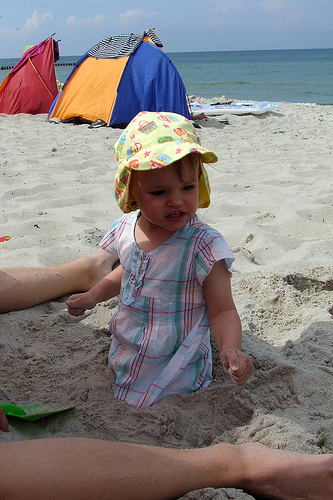

In [70]:
raw_img = PIL.Image.open(os.path.join(IMG_PATH, dev_list[199]))
preprocessed_img = preprocess(raw_img).to(DEVICE)
encoded_img = img_encoder(preprocessed_img.unsqueeze(0)).reshape((512))
caption = new_greedy_decoder(encoded_img)
print(caption)
raw_img

['a', 'black', 'dog', 'is', 'swimming', 'through', 'water', '.', '<EOS>']


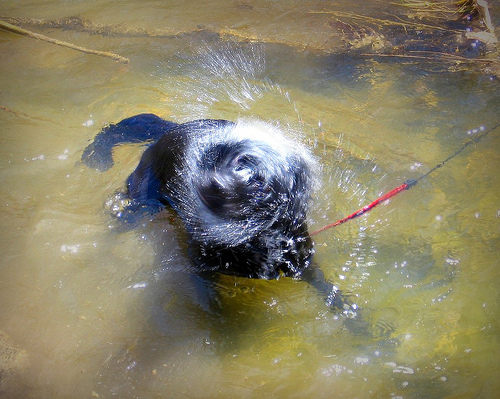

In [71]:
raw_img = PIL.Image.open(os.path.join(IMG_PATH, dev_list[12]))
preprocessed_img = preprocess(raw_img).to(DEVICE)
encoded_img = img_encoder(preprocessed_img.unsqueeze(0)).reshape((512))
caption = new_greedy_decoder(encoded_img)
print(caption)
raw_img

The result should look pretty good for most images, but the model is prone to hallucinations.

## Part V - Beam Search Decoder (24 pts)

**TODO** Modify the simple greedy decoder for the caption generator to use beam search.
Instead of always selecting the most probable word, use a *beam*, which contains the n highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). I recommend that you use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the n most probable sequences.

Then, for each sequence, compute the n most likely successor words. Append the word to produce n new sequences and compute their score. This way, you create a new list of n*n candidates.

Prune this list to the best n as before and continue until `MAX_LEN` words have been generated.

Note that you cannot use the occurence of the `"<EOS>"` tag to terminate generation, because the tag may occur in different positions for different entries in the beam.

Once `MAX_LEN` has been reached, return the most likely sequence out of the current n.

In [107]:
import sys
def img_beam_decoder(n, img):
    model.eval()
    # Initialize the beam with the <START> token
    start_token_id = word_to_id["<START>"]
    end_token_id = word_to_id["<EOS>"]
    start_sequence = ([start_token_id], 1.0)  # (sequence, probability)
    beam = [start_sequence]

    # Perform beam search
    for _ in range(MAX_LEN - 1):
        candidates = []  # Stores the candidates for the next step

        for sequence, score in beam:
            # For each sequence in beam, calculate.
            input_seq = torch.zeros((1, MAX_LEN), dtype=torch.long).to(DEVICE)
            input_seq[0, :len(sequence)] = torch.tensor(sequence, dtype=torch.long).to(DEVICE)
            img_encoding_exp = img.unsqueeze(0)  # Shape [1, 512]
            with torch.no_grad():
                logits = model(img_encoding_exp.to(DEVICE), input_seq)
            probs = torch.softmax(logits[:, len(sequence) - 1, :], dim=-1).squeeze(0)

            # Pruning
            top_k_probs, top_k_ids = torch.topk(probs, n)  # Shape: [beam_width]
            for prob, token_id in zip(top_k_probs, top_k_ids):
                new_sequence = sequence + [token_id.item()]
                new_score = score * prob.item()  # Multiply probabilities
                candidates.append((new_sequence, new_score))

            candidates = sorted(candidates, key=lambda x: x[1], reverse=True)[:n]
            beam = candidates  # Update the beam with the best candidates

    best_sequence = max(beam, key=lambda x: x[1])[0]
    # Remove start and end tokens
    if end_token_id in best_sequence:
        best_sequence = best_sequence[1:best_sequence.index(end_token_id)]
    else:
        best_sequence = best_sequence[1:]
    return [id_to_word[idx] for idx in best_sequence]

**TODO** Finally, before you submit this assignment, please show 3 development images, each with 1) their greedy output, 2) beam search at n=3 3) beam search at n=5.

In a lot of cases, the beam search appears to be better, but in some cases it is similar. Greedy decoder does not seem to be doing a bad job at all.

Beam Search with n=5 sometimes tends to just correct the grammar and in some cases also hallucinates.


Greedy Output for 3100442775_6e2659b973.jpg: ['a', 'man', 'is', 'doing', 'a', 'trick', 'on', 'a', 'skateboard', '.', '<EOS>']
Beam Search Output for 3100442775_6e2659b973.jpg with n=3: ['a', 'man', 'is', 'doing', 'a', 'trick', 'on', 'a', 'skateboard', '.']
Beam Search Output for 3100442775_6e2659b973.jpg with n=5: ['a', 'man', 'is', 'doing', 'a', 'trick', 'on', 'a', 'skateboard', '.']


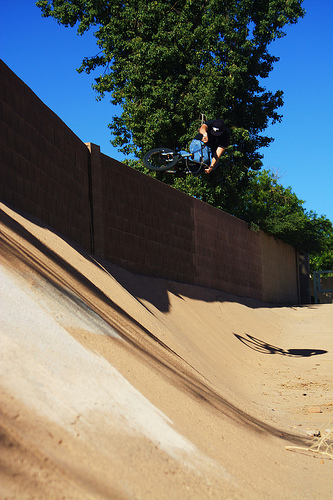

Greedy Output for 576920249_df1bdc2068.jpg: ['a', 'group', 'of', 'people', 'are', 'standing', 'in', 'front', 'of', 'a', 'white', 'house', '.', '<EOS>']
Beam Search Output for 576920249_df1bdc2068.jpg with n=3: ['a', 'group', 'of', 'people', 'are', 'standing', 'in', 'front', 'of', 'a', 'brick', 'wall', '.']
Beam Search Output for 576920249_df1bdc2068.jpg with n=5: ['a', 'group', 'of', 'people', 'are', 'standing', 'on', 'the', 'street', '.']


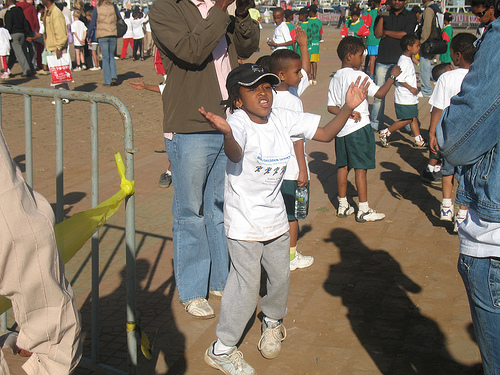

Greedy Output for 1731546544_9fbf14617b.jpg: ['a', 'black', 'dog', 'is', 'running', 'through', 'the', 'water', '.', '<EOS>']
Beam Search Output for 1731546544_9fbf14617b.jpg with n=3: ['a', 'black', 'dog', 'splashes', 'through', 'the', 'water', '.']
Beam Search Output for 1731546544_9fbf14617b.jpg with n=5: ['a', 'black', 'dog', 'splashes', 'through', 'the', 'water', '.']


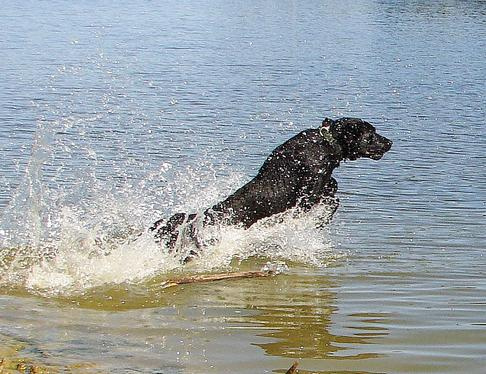

In [ ]:
for i in range(3):
    img_number = np.random.randint(1, 500)
    raw_img = PIL.Image.open(os.path.join(IMG_PATH, dev_list[img_number]))
    preprocessed_img = preprocess(raw_img).to(DEVICE)
    encoded_img = img_encoder(preprocessed_img.unsqueeze(0)).reshape((512))

    # Get greedy caption
    greedy_caption = new_greedy_decoder(encoded_img)
    print(f"Greedy Output for {dev_list[img_number]}: {greedy_caption}")

    # Get beam search captions with n=3 and n=5
    beam3_caption = img_beam_decoder(3, encoded_img)
    print(f"Beam Search Output for {dev_list[img_number]} with n=3: {beam3_caption}")

    beam5_caption = img_beam_decoder(5, encoded_img)
    print(f"Beam Search Output for {dev_list[img_number]} with n=5: {beam5_caption}")

    # Display the image
    display(raw_img)